# <img src="https://marcello-sega.github.io/pytim/_static/logo.png" alt="logo" style="width: 50px;display: inline-block;"/>  An introduction to pytim  


This notebook goes through a basic example of the usage of Pytim, and assumes that you already have a working Pytim package. The ITIM class will be used to analyze the layers of a macroscopically flat water/vapour interface. 

### 1. Importing the main modules

Pytim relies on [MDAnalysis](http://mdanalysis.org) to read different trajectory/topology/configuration formats. In this notebook we will use ony some basic functionality of MDAnalysis: you might want to become more familiar with it to perform more complex analysis. We also import `numpy` as most MDAnalysis objects can be accessed as numpy arrays.

In [1]:
import MDAnalysis as mda
import numpy as np

the next module we want to import is `pytim` itself. This loads (among other things) the [`ITIM`](https://marcello-sega.github.io/pytim/ITIM.html), [`GITIM`](https://marcello-sega.github.io/pytim/GITIM.html) and [`WillardChandler`](https://marcello-sega.github.io/pytim/WillardChancler.html) classes as well as the [`observables`](https://marcello-sega.github.io/pytim/observables.html) and [`utilities`](https://marcello-sega.github.io/pytim/utilities.html) modules.

In [2]:
import pytim

Pytim comes with a set of configurations/trajectories for a number of simple systems, meant for testing purposes. They can be accessed from the `pytim.datafiles` module, so let's load all of them:

In [3]:
from pytim.datafiles import *

### 2. First steps: loading a sample configuration

Let's see which configuration files are available:

In [4]:
print pytim_data.config

['WATER_XYZ', 'WATER_550K_GRO', 'MICELLE_PDB', 'WATER_520K_GRO', 'WATER_GRO', 'FULLERENE_PDB', 'WATER_PDB', 'WATERSMALL_GRO', 'CCL4_WATER_GRO']


These are the names of variables pointing to the actual files in the distribution. 
Let's load a water configuration file:

In [5]:
u = mda.Universe(WATER_PDB)

Let's now figure out what's in this file:

In [6]:
print u
print len(u.residues)," residues of type:",
print np.unique(u.atoms.resnames)
print "The atoms in the system are of type:",
print np.unique(u.atoms.names)

<Universe with 12000 atoms>
4000  residues of type: ['SOL']
The atoms in the system are of type: ['H' 'O']


### 3. Visualize structures in the notebook with ```nglview```

Now we would like to visulalize the strcutre in this notebook.
A very convenient way is to use the `nglview` module. To install it you can simply do:

    pip install --user nglview

You might have to enable the javascript extension like this:

    jupyter nbextension install --py nglview --user
    jupyter nbextension enable nglview --user --py


In [7]:
import nglview as nv

In [8]:
# we need to fix a bug here:
u.residues.resids=1
view = nv.show_mdanalysis(u)
view.camera = 'orthographic'
view.add_unitcell()
view

In [9]:
view.render_image()

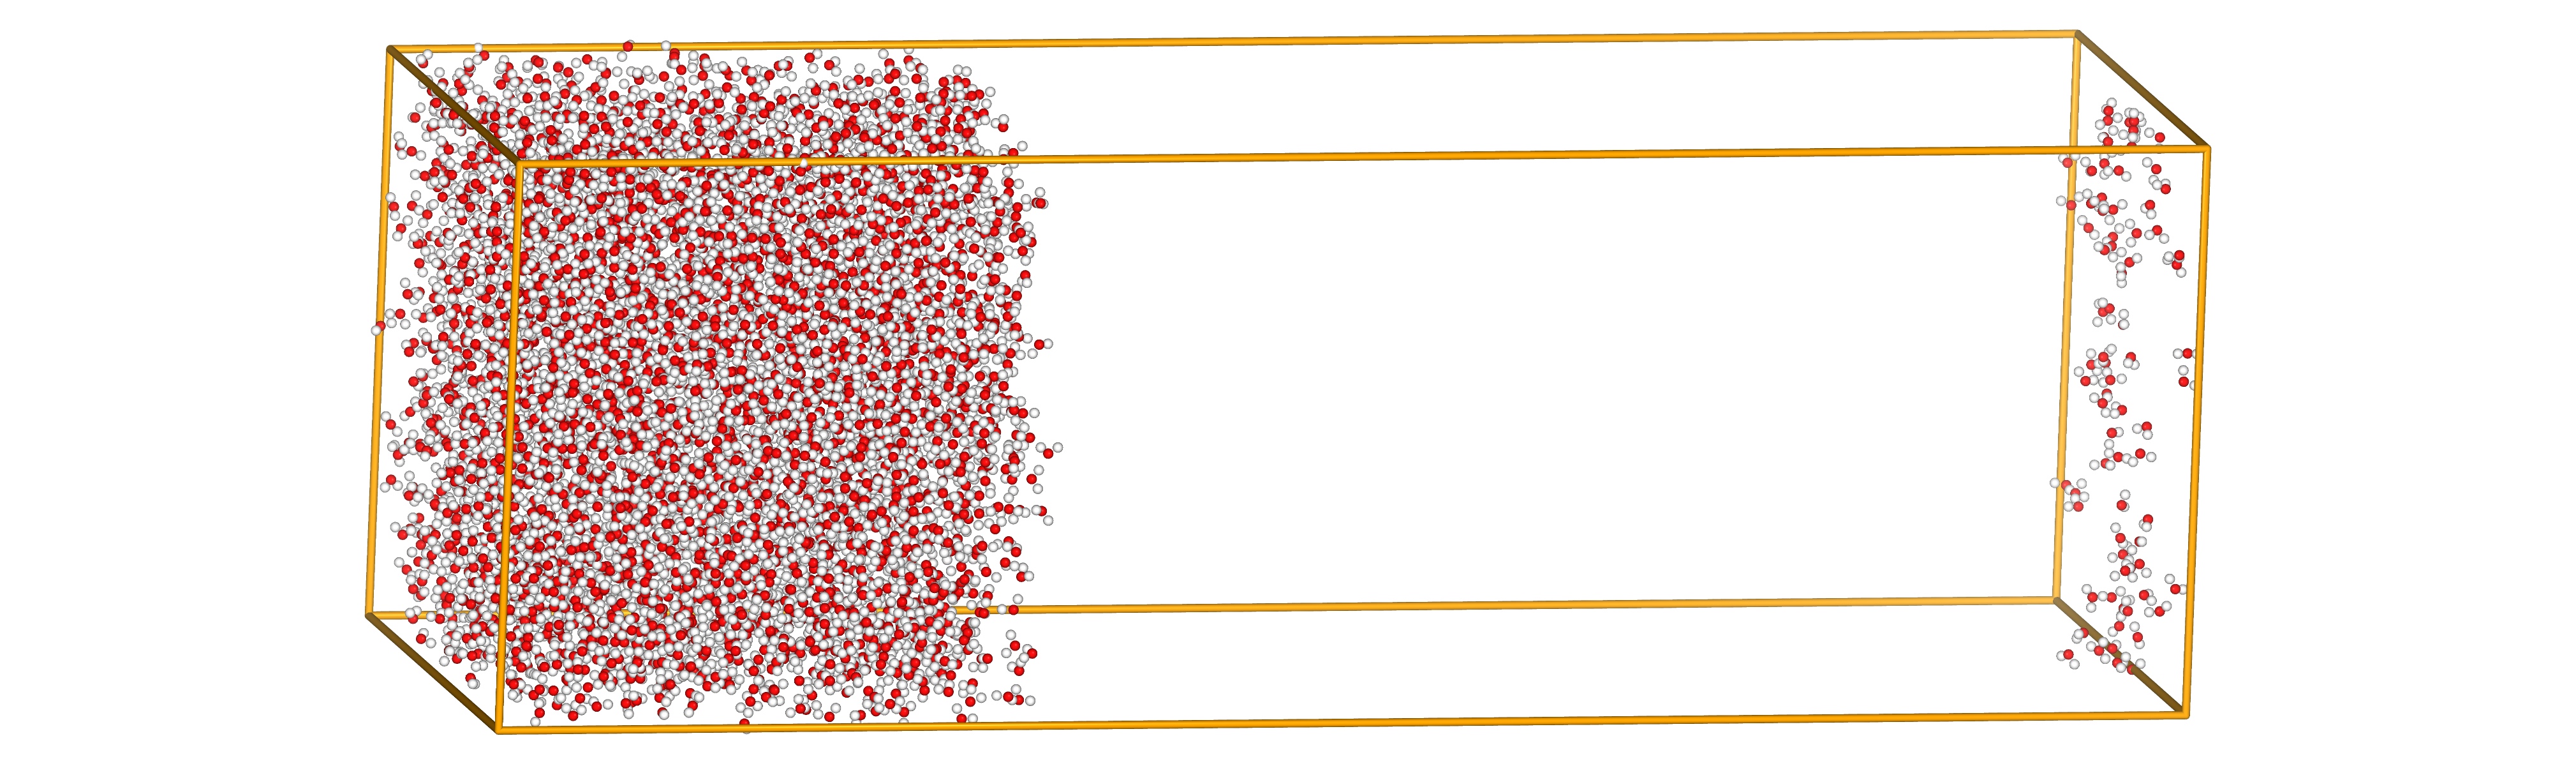

In [10]:
view._display_image()

Good, it works, and one can see that the system crosses the PBCs. 

### 4. The ```ITIM``` class: surface atoms of macroscopically flat interfaces

Let's initialize an ITIM interface. Let's check first what are the default arguments:

In [11]:
help(pytim.ITIM.__init__)

Help on method __init__ in module pytim.itim:

__init__(self, universe, mesh=0.4, alpha=2.0, normal='guess', group=None, radii_dict=None, max_layers=1, cluster_cut=None, cluster_threshold_density=None, molecular=True, extra_cluster_groups=None, info=False, multiproc=True, centered=False, warnings=False, **kargs) unbound pytim.itim.ITIM method



You can get a full help with 

    help(pytim.ITIM)
    
For now, we assume we don't want anything fancy for this first test, so let's go witht the default arguments, but let's center the liquid slab in the middle of the box

In [12]:
inter = pytim.ITIM(u,centered='middle')

That's it. Now our layers have been computed, let's see their composition:

In [13]:
print inter.layers

[[<AtomGroup with 780 atoms>]
 [<AtomGroup with 777 atoms>]]


This is a list of lists... the layers in the upper interface are:

In [14]:
print inter.layers[0]

[<AtomGroup with 780 atoms>]


In [15]:
inter.layers[0,0]

<AtomGroup with 780 atoms>

```ITIM``` is not the only way to calculate surface atoms or surfaces. More information on the other modules can be found in the [online manual](https://marcello-sega.github.io/pytim/index.html) or in other notebooks in this distribution 

### 5. Using the information from the layer groups

We can use these groups as any other `MDAnalysis` group, to perform simple or more complex operations. For example, we can easily check the distribution along the Z axis of the atoms in those layers:

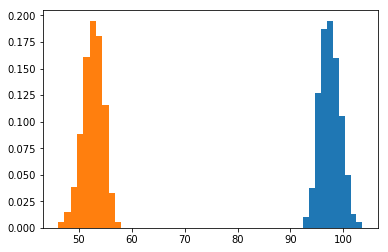

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
UPPER=0
LOWER=1
Z=2
plt.hist(inter.layers[UPPER,0].positions[::,Z], 10, normed=1)
plt.hist(inter.layers[LOWER,0].positions[::,Z], 10, normed=1)
plt.show()

Note that the layer distributions are roughly symmetric around the origin, while the configuration was crossing the PBCs. This is because, internally, pytim always tries to center the denser phase in the middle of the box, if possible.

This is a very simple example that calculates the distribution in space of surface atoms. More complex observables can be computed with the tools available in the [```pytim.observables```](https://marcello-sega.github.io/pytim/observables.html) module



### 6. Visualizing surface atoms with ```nglview```

```nglview``` can be used also to visualize the surface atoms. We just need to add the layer groups to the representation:

In [17]:
w = nv.show_mdanalysis(u)
w.camera = 'orthographic'
upper=inter.layers[UPPER,0].indices
lower=inter.layers[LOWER,0].indices
w.add_representation('ball+stick',selection=upper,color='blue',radius=0.8,opacity=0.5)
w.add_representation('ball+stick',selection=lower,color='blue',radius=0.8,opacity=0.5)
w.add_unitcell()
w

In [18]:
w.render_image()

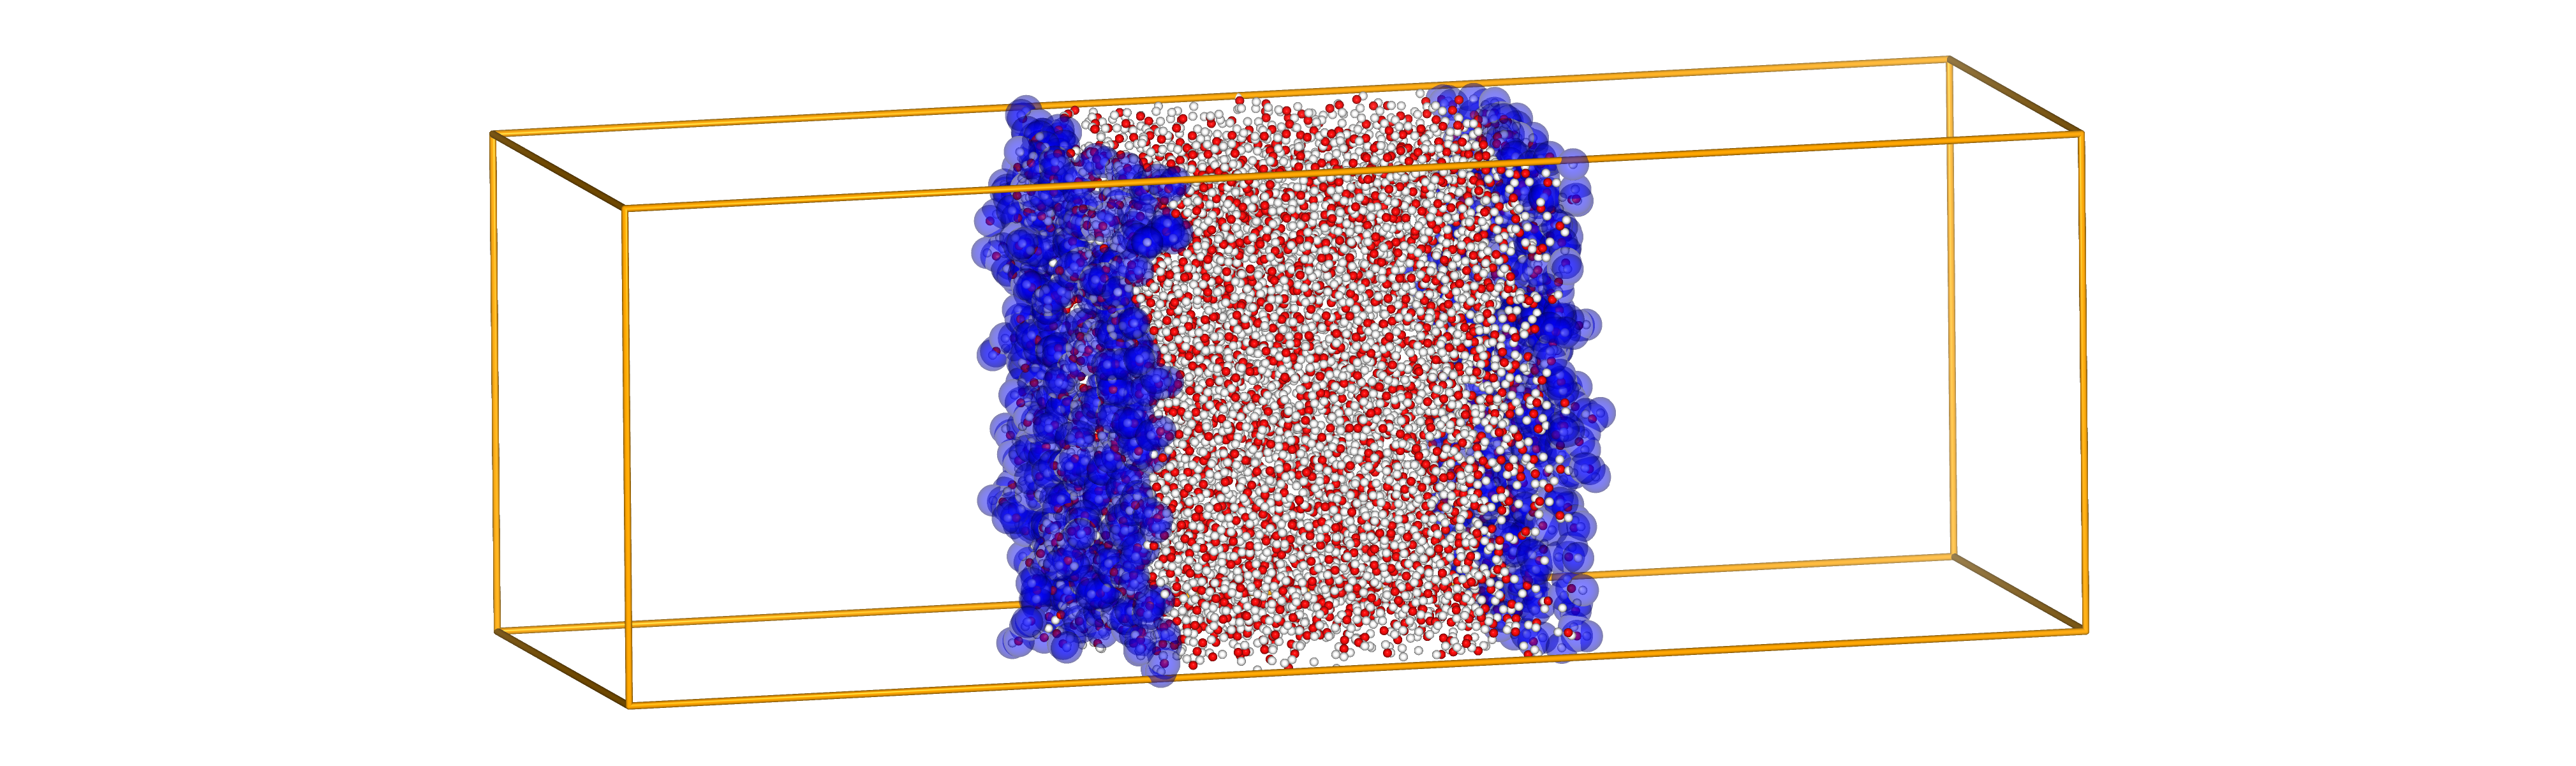

In [19]:
w._display_image()

### 6. Saving layer information to PDB

It is possible to save to file (PDB) including the information on the surface atoms, with the command: 

In [20]:
inter.writepdb("frame.pdb",centered=True)

Atoms in the liquid phase have `beta == 0`, those in the n-th layer, `beta == n`, and those in the gas phase `beta == 0.5` .
Let's open the pdb file and see what's in:

In [21]:
open('frame.pdb','r').readlines()[:30]


['HEADER    \n',
 'TITLE     MDANALYSIS FRAMES FROM 0, SKIP 1: Created by PDBWriter\n',
 'REMARK     THIS IS A SIMULATION BOX\n',
 'CRYST1   50.000   50.000  150.000  90.00  90.00  90.00 P 1           1\n',
 'MODEL         1\n',
 'ATOM      1  O   SOL S   1      28.620   2.010  11.370  1.00  0.00      SYST O\n',
 'ATOM      2  H   SOL S   1      28.420   2.470  10.510  1.00  0.00      SYST H\n',
 'ATOM      3  H   SOL S   1      29.610   1.970  11.510  1.00  0.00      SYST H\n',
 'ATOM      4  O   SOL S   1      14.690   7.330  24.580  1.00  0.00      SYST O\n',
 'ATOM      5  H   SOL S   1      15.660   7.570  24.640  1.00  0.00      SYST H\n',
 'ATOM      6  H   SOL S   1      14.140   8.010  25.060  1.00  0.00      SYST H\n',
 'ATOM      7  O   SOL S   1       3.880  32.660  36.760  1.00  0.00      SYST O\n',
 'ATOM      8  H   SOL S   1       4.560  32.870  37.460  1.00  0.00      SYST H\n',
 'ATOM      9  H   SOL S   1       2.960  32.880  37.110  1.00  0.00      SYST H\n',
 'ATOM

Notice the column before the ```'SYST'``` string, which holds the ```beta``` information.

The value of ```beta``` can be used in molecular visualization packages, for example in [```VMD```](www.ks.uiuc.edu/Research/vmd/) to select the different layers when creating a representation.